# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Импортируем необходимые билиотеки

In [2]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from scipy.interpolate import interp1d
from tqdm import tqdm

In [3]:
PTH_FACES = '/datasets/faces/final_files'
PTH_LABELS = '/datasets/faces/labels.csv'

In [4]:
if os.path.exists(PTH_LABELS) and os.path.exists(PTH_FACES):
    df = pd.read_csv(PTH_LABELS)
    print("Датасет успешно загружен, папка с изображениями найдена")
else:
    print("Проверьте правильность пути")

Датасет успешно загружен, папка с изображениями найдена


In [5]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


В файле с описанием только имя файла и возраст, являющийся целевым признаком 

Помимо возраста, исследуем основные характеристики представленных изображений: размер, яркость

In [6]:
def extra_pic_info(x):
    '''
    Add 'width', 'height', 'depth', 'brightness' in dataframe
    '''
    image = cv2.imread(PTH_FACES + '/' + x)
    width, height, depth = image.shape #image size
    image_br = np.sum(image) #current brightness
    return pd.Series([width, height, depth, image_br])

In [7]:
tqdm.pandas()
df[['width', 'height', 'depth', 'image_br']] = df['file_name'].progress_apply(lambda x: extra_pic_info(x))

100%|██████████| 7591/7591 [07:59<00:00, 15.83it/s]


In [8]:
# image brightness / max brightness for current image
df['ab_bright'] = df['image_br'] / (df['width'] * df['height'] * df['depth'] * 255) 
df['ab_bright'] = round(df['ab_bright'], 4)
df = df.drop('image_br', axis=1)

In [9]:
df.head()

,file_name,real_age,width,height,depth,ab_bright
0,000000.jpg,4,114,114,3,0.4397
1,000001.jpg,18,784,784,3,0.3118
2,000002.jpg,80,133,133,3,0.5635
3,000003.jpg,50,370,370,3,0.2505
4,000004.jpg,17,212,212,3,0.4482


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_name  7591 non-null   object 
 1   real_age   7591 non-null   int64  
 2   width      7591 non-null   int64  
 3   height     7591 non-null   int64  
 4   depth      7591 non-null   int64  
 5   ab_bright  7591 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 356.0+ KB


In [11]:
print(f'В папке {PTH_FACES} находится {len(os.listdir(PTH_FACES))} файлов')
print(f'Количество файлов совпадает с количеством записей: {len(os.listdir(PTH_FACES)) == len(df)}')

В папке /datasets/faces/final_files находится 7591 файлов
Количество файлов совпадает с количеством записей: True


У нас 7591 фотография с возрастом от 1 до 100, тоесть на один год в среднем около 76 фотографий, учитывая особенность собранного сета, на некоторые года будет приходится значительно меньше фотографий и соответственно модели будет сложнее выявить закономерности. Но с учетом задачи МАЕ < 8 вполне достаточно
    
Для повышения качества можно пойти двумя путями(при условии что нельзя найти еще размеченных датасетов):\
    - попробывать увеличить количество фотографий обеднённых периодов, дублируя и применяя аугментацию (зум, наклоны и пр.);\
    - свести задачу к классификации для более удобных периодов возраста для бизнеса(например люди старше 60 лет или 0-3, 3-5, 5-7 и т.д.)

In [12]:
df.describe()

,real_age,width,height,depth,ab_bright
count,7591.000000,7591.000000,7591.000000,7591.0,7591.000000
mean,31.201159,464.093927,464.733764,3.0,0.388619
std,17.145060,331.289883,330.834794,0.0,0.125075
min,1.000000,47.000000,47.000000,3.0,0.047800
25%,20.000000,220.000000,220.000000,3.0,0.299700
50%,29.000000,384.000000,385.000000,3.0,0.382500
75%,41.000000,632.000000,632.000000,3.0,0.471500
max,100.000000,4466.000000,4466.000000,3.0,0.872500


В наборе 7591 файлов, средний возраст 31 год. В наборе представлены фотографии людей от 1 до 100 лет.

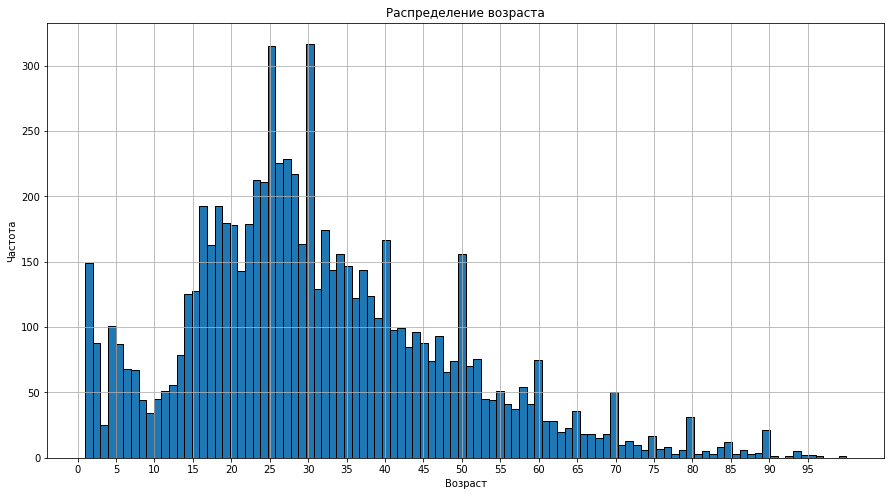

In [13]:
df.real_age.hist(bins=100, figsize=(15, 8), edgecolor = "black")
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.xticks(np.arange(0, 100, step=5));

На распределении фотографий по возрастам заметна концентрация значений 1-5, 15-20, 25-30. А также концентрация вокруг значений кратных 5 от 25 лет. Это связано с особенностью сборки данного датасета, он был собран из нескольких размеченных коллекций фотографий. Скорее всего датасет с разметкой кратной 5 годам нежелателен для обучения нейросети, так как он создаст проблему в преодолении порога ошибки в +/-5 лет

In [14]:
def pic_sample(df, col, trash, lower=True, sample=4):
    '''
    Return 4 pictures for different condition
    
    df -- pd.DataFrame
    col -- column
    trash -- trashhold
    lower -- up or down
    sample -- quantity
    '''
    if lower == True:
        df_for_pic = df[df[col] < trash].sample(sample, random_state=12345)
        fig = plt.figure(figsize=(18, 9))
        for x in range(len(df_for_pic)):
            fig.add_subplot(1, 5, x + 1)
            plt.imshow(Image.open(PTH_FACES + '/' + df_for_pic.iloc[x]['file_name']))
            plt.title(df_for_pic.iloc[x]['real_age'])
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
    else:
        df_for_pic = df[df[col] > trash].sample(sample, random_state=12345)
        fig = plt.figure(figsize=(18, 18))
        for x in range(len(df_for_pic)):
            fig.add_subplot(1, 5, x + 1)
            plt.imshow(Image.open(PTH_FACES + '/' + df_for_pic.iloc[x]['file_name']))
            plt.title(df_for_pic.iloc[x]['real_age'])
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        

Посмотрим на фотографии с минимальным и максимальным возрастов представленным в датасете

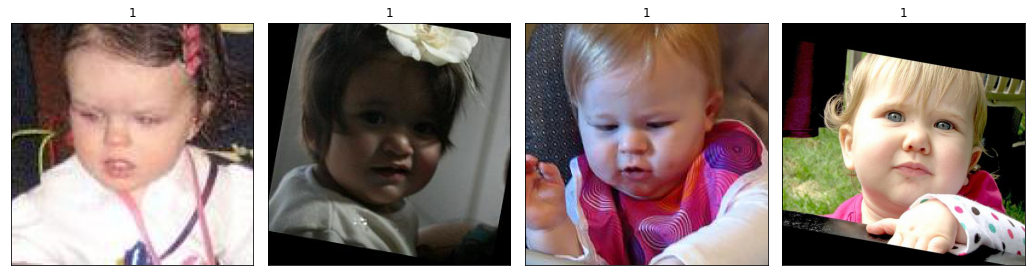

In [15]:
pic_sample(df, 'real_age', 2, lower=True, sample=4)

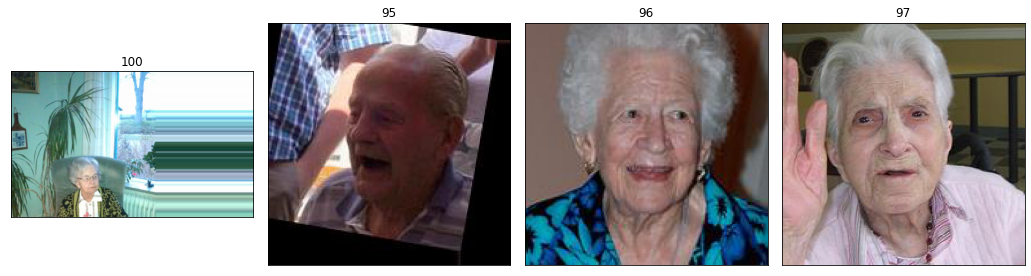

In [16]:
pic_sample(df, 'real_age', 90, lower=False, sample=4)

Ожидаемые значения возраста совпадают, видно что некоторые фотографии преобразованы поворотом до примерно вертикального положения лица. Также применялось смещение

Построим гистограмму распределения яркости изображений

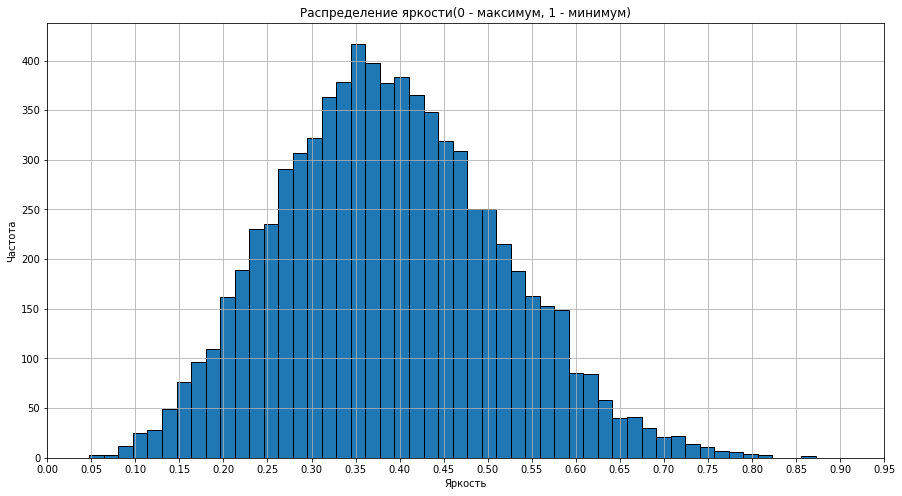

In [17]:
df.ab_bright.hist(bins=50, figsize=(15, 8), edgecolor = "black")#, width=.7)
plt.title('Распределение яркости(0 - максимум, 1 - минимум)')
plt.xlabel('Яркость')
plt.ylabel('Частота')
plt.xticks(np.arange(0, 1, step=.05));

В общем яркость у фотографий распределена равномерно вокруг 0,35-0,4, но встречаются как очень темные так и очень светлые фотографии. Посмотрим на них ниже

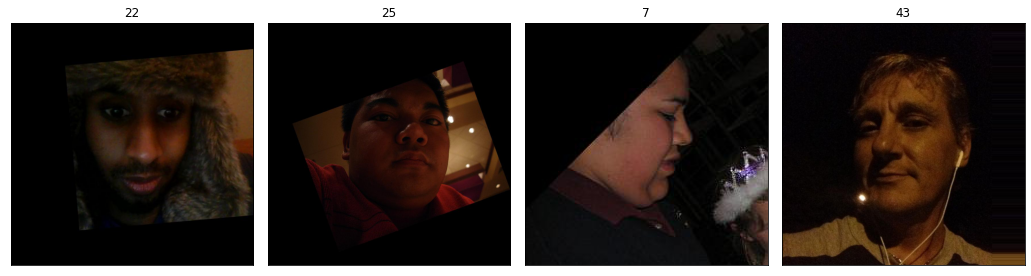

In [18]:
pic_sample(df, 'ab_bright', 0.09, lower=True, sample=4)

Видно что низкая яркость вызвана не только условими съемки, но и способом преобразования изображений(черный фон)

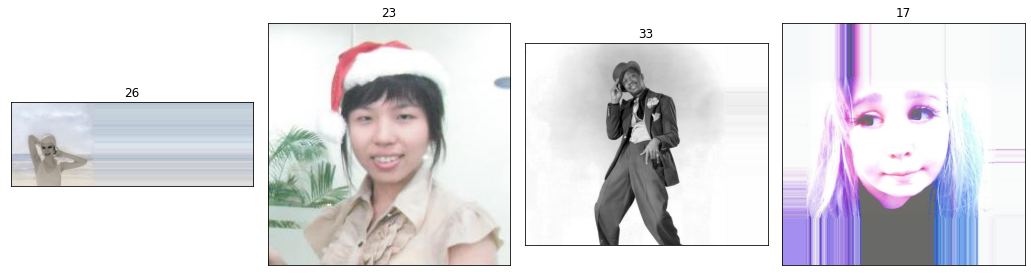

In [19]:
pic_sample(df, 'ab_bright', 0.8, lower=False, sample=4)

Для очень светлых изображений причина высокой яркости в условиях съемки. Также видим изображение в оттенках серого

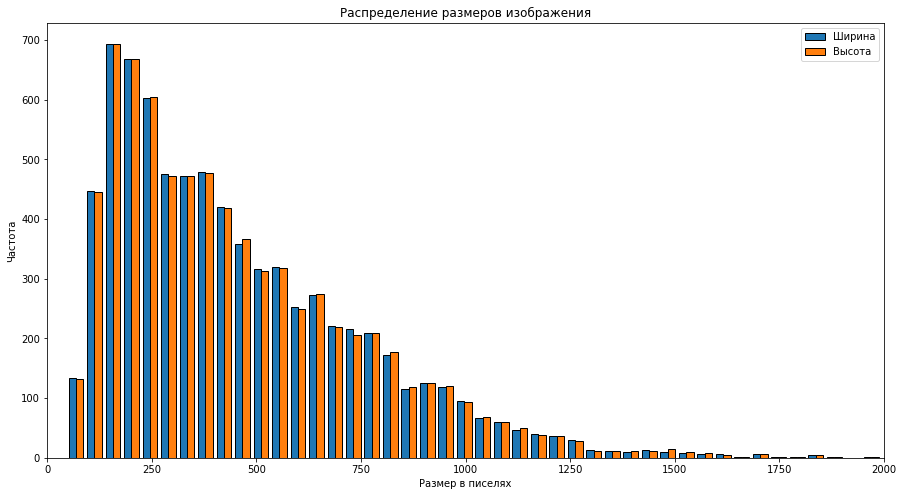

In [20]:
plt.figure(figsize=(15,8))
plt.hist([df['width'], df['height']], bins=100, edgecolor = "black")
plt.title('Распределение размеров изображения')
plt.legend(['Ширина', 'Высота'])
plt.xlabel('Размер в писелях')
plt.ylabel('Частота')
plt.xlim(0, 2000);
plt.show()

Размеры изображений представлены от 47 до 4466 пикселей. Для высоких значений разрешения информации будет избыточно для обучения сети, а для фотографий низкого определить возраст будет затруднительно, как на примере ниже

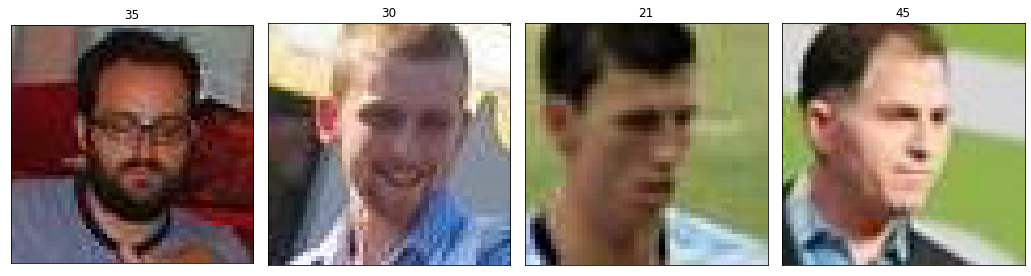

In [21]:
pic_sample(df, 'width', 60, lower=True, sample=4)

Проверим соотношение сторон

In [22]:
#aspect ratio
(df['width']/df['height']).describe()

count    7591.000000
mean        1.000732
std         0.059985
min         0.335000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.144654
dtype: float64

Почти все изображения имеют соотношение сторон 1:1

**Вывод:**

В данном разделе провели анализ фотографий лиц людей для подготовки к обучению нейронной сети предсказывающей возраст по фотографии.

Для обучения представлено 7591 файл в формате 'jpg'. Целевой признак возраст представлен от 1 года до 100 лет. Округление идет в сторону полных лет. Распределение фотографий по возрасту не равномерное. Встречаются всплески значений 0-5 лет и основное количество лежит в пределах от 15 до 40 лет. Также значительное число фотографий концентрируется на значениях кратных 5 годам старше 25 лет. Что создаст проблему для преодоления порога ошибки в +/- 5 лет.

Встречаются фотографии с избыточной и недостаточной яркостью. Возможно для таких фотографий необходимо проводить предобработку выравниванием контрастности, регулировкой гистграммы и т.п.

Большинство фотографий подходящего разрешения либо избыточно высокого. Есть небольшое число фотографий низкого разрешения, возможно недостаточного для определения возраста

Соотношение сторон практически всех фотографий в датасете 1:1


## Обучение модели

Будем использовать модель на основе ResNet101
с замороженными нижними слоями,
с глобальным пулингом с усреднением GlobalAveragePooling2D, 
оптимизатор Adam с шагом 0.0001, 
последний полносвязный слой с одним выходом Dense,
на 30 эпохах


Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import ResNet101 #for test
from tensorflow.keras.optimizers import Nadam #for test
import pandas as pd


def load_test(path):
    datagen_test = ImageDataGenerator(rescale=(1.0/255.0), validation_split=0.2)

    test_datagen_flow = datagen_test.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


def load_train(path):
    datagen_train = ImageDataGenerator(rescale=(1.0/255.0), 
                                       validation_split=0.2, 
                                       rotation_range=15,
                                       width_shift_range=0.2, 
                                       height_shift_range=0.2)

    train_datagen_flow = datagen_train.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate = 0.0001)
    backbone = ResNet101(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, 
                train_datagen_flow, 
                val_datagen_flow, 
                batch_size=None, 
                epochs=30,
                steps_per_epoch=None, 
                validation_steps=None):

    if steps_per_epoch == None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps == None:
        validation_steps = len(val_datagen_flow)

    model.fit(train_datagen_flow,  
              validation_data=val_datagen_flow,
              steps_per_epoch=steps_per_epoch, 
              epochs=epochs,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)
    return model
```

```
Train for 380 steps, validate for 95 steps

Epoch 1/30

2023-02-09 03:58:54.448935: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-02-09 03:58:56.490979: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

380/380 - 132s - loss: 206.0095 - mae: 10.4086 - val_loss: 622.1241 - val_mae: 19.6826

Epoch 2/30

380/380 - 94s - loss: 99.9755 - mae: 7.5593 - val_loss: 112.7592 - val_mae: 8.3266

Epoch 3/30

380/380 - 95s - loss: 72.3832 - mae: 6.4641 - val_loss: 78.0123 - val_mae: 6.6399

Epoch 4/30

380/380 - 95s - loss: 59.6864 - mae: 5.9625 - val_loss: 86.6247 - val_mae: 7.1185

Epoch 5/30

380/380 - 95s - loss: 48.9458 - mae: 5.3386 - val_loss: 92.7743 - val_mae: 6.9976

Epoch 6/30

380/380 - 95s - loss: 39.7247 - mae: 4.8513 - val_loss: 78.1914 - val_mae: 6.5977

Epoch 7/30

380/380 - 94s - loss: 30.5781 - mae: 4.2527 - val_loss: 100.0305 - val_mae: 7.7779

Epoch 8/30

380/380 - 95s - loss: 28.7368 - mae: 4.1348 - val_loss: 70.7380 - val_mae: 6.2755

Epoch 9/30

380/380 - 95s - loss: 25.0284 - mae: 3.8781 - val_loss: 68.3350 - val_mae: 6.2298

Epoch 10/30

380/380 - 94s - loss: 22.7534 - mae: 3.6860 - val_loss: 68.1383 - val_mae: 6.1253

Epoch 11/30

380/380 - 94s - loss: 22.9955 - mae: 3.6597 - val_loss: 86.1482 - val_mae: 6.9917

Epoch 12/30

380/380 - 95s - loss: 22.6398 - mae: 3.6373 - val_loss: 75.9467 - val_mae: 6.3502

Epoch 13/30

380/380 - 95s - loss: 18.2161 - mae: 3.2654 - val_loss: 73.4526 - val_mae: 6.4842

Epoch 14/30

380/380 - 95s - loss: 15.2263 - mae: 3.0159 - val_loss: 60.9022 - val_mae: 5.7043

Epoch 15/30

380/380 - 95s - loss: 13.2782 - mae: 2.7901 - val_loss: 70.9260 - val_mae: 5.9598

Epoch 16/30

380/380 - 94s - loss: 14.8905 - mae: 2.9294 - val_loss: 66.1343 - val_mae: 6.2662

Epoch 17/30

380/380 - 94s - loss: 16.7383 - mae: 3.1220 - val_loss: 62.6418 - val_mae: 5.8658

Epoch 18/30

380/380 - 95s - loss: 15.1615 - mae: 2.9586 - val_loss: 66.7702 - val_mae: 5.8100

Epoch 19/30

380/380 - 95s - loss: 18.5535 - mae: 3.2311 - val_loss: 69.1327 - val_mae: 6.1820

Epoch 20/30

380/380 - 94s - loss: 14.2471 - mae: 2.8532 - val_loss: 79.4964 - val_mae: 6.8498

Epoch 21/30

380/380 - 95s - loss: 14.1947 - mae: 2.8865 - val_loss: 66.6205 - val_mae: 5.9573

Epoch 22/30

380/380 - 94s - loss: 12.8105 - mae: 2.7194 - val_loss: 61.6943 - val_mae: 5.8631

Epoch 23/30

380/380 - 95s - loss: 13.4321 - mae: 2.7883 - val_loss: 67.0996 - val_mae: 5.8856

Epoch 24/30

380/380 - 94s - loss: 10.8855 - mae: 2.5370 - val_loss: 58.6908 - val_mae: 5.7457

Epoch 25/30

380/380 - 95s - loss: 9.4384 - mae: 2.3605 - val_loss: 59.1359 - val_mae: 5.6499

Epoch 26/30

380/380 - 95s - loss: 9.3264 - mae: 2.3245 - val_loss: 57.4528 - val_mae: 5.6270

Epoch 27/30

380/380 - 95s - loss: 23.3496 - mae: 3.3550 - val_loss: 72.9077 - val_mae: 6.3657

Epoch 28/30

380/380 - 94s - loss: 16.9504 - mae: 3.1300 - val_loss: 63.0855 - val_mae: 5.9006

Epoch 29/30

380/380 - 94s - loss: 8.8916 - mae: 2.2961 - val_loss: 61.7795 - val_mae: 5.7440

Epoch 30/30

380/380 - 95s - loss: 7.6181 - mae: 2.1212 - val_loss: 56.7960 - val_mae: 5.4936

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']
  
95/95 - 8s - loss: 56.7960 - mae: 5.4936

Test MAE: 5.4936

'''

# Анализ обученной модели

Проведено разделение данных на тренировочную и тестовую выборки. Провели преобразование случайным поворотом до 15градусов. Сдвиг по вертикале и горизонтале на 20%
Модель на 30-ой эпохе обучилась до МАЕ 5.4936
После 10 эпох у модели наблюдается замеделение роста качества на валидационной выборке - модель начинает переобучаться.

**Вывод:**
Нами проведено обучение модели для предсказания возраста по фотографии с помощью нейронной сети.
Для обучения была предоставлена коллекция фотографий людей возрастом от 1 до 100 лет. В наибольшем объеме представлены фотографии от 1-5 лет и от 15 до 40 лет. Фотографий других возрастов меньше. Соответственно на них ожидаем получить большую ошибку. Также из-за того что данный датасет собран из нескольких других, есть всплески концентраций вокруг значений кратных 5 после 25 лет, что может помешать достичь МАЕ < 5

Фотографии представленны различной яркости, что хорошо для обучения нейронной сети.
Встречаются фотографии в очень низком разрешении(~50pix) по которым возможно затруднительно будет установить возрастные признаки

Для повышения качества обучения модели была проведена аугментация фотографий 

Обучение производилось на Tesla V100-SXM2-32GB обучение заняло меньше часа.

Целевое значение метрики МАЕ 5.4936 < 8 получено
При этом та же модель, при грубой фильтрации кратно 5 > 25 лет, на 30 эпохе покажет 5,4 а на 27 минимум был 5,33
Можно меньшим шагом, большим количеством эпох и подбором параметров оптимизатора попробывать добиться лучшего качества, но думаю прирост будет не особо значительным из-за переобучения

**Учитывая задачи исследования данная модель, с учетом полученной ошибки, может быть использованна для анализа и предложения товаров покупателям. Кроме товаров для которых важен возраст покупателей (например детям товары для более старших категорий, либо товары 18+)\
Для целей контроля продаж алкоголя модель, учитывая точность, не совсем подойдет. Точнее будет давать слишком много ложных срабатываний на всех покупателей 18+МАЕ**

